### NFL inference and simulation with `turf`

---

This notebook runs a hierarchical Bayesian inference model on 2023 NFL season results to estimate team offensive and defensive strengths, visualize the results, and simulate game outcomes.

David Fleming, 2023

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from turf import scrape, utils, inference

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

**Initiate and fit model**

---


In [2]:
# Pull season results to-date
season = scrape.NFLSeason(year=2020, path="../turf/tests/test_data/nfl_sample.csv")

In [3]:
# Initialize model
model = inference.IndependentNegativeBinomialMixture(season, path="../turf/tests/test_data/nfl_example_nb_trace.nc")

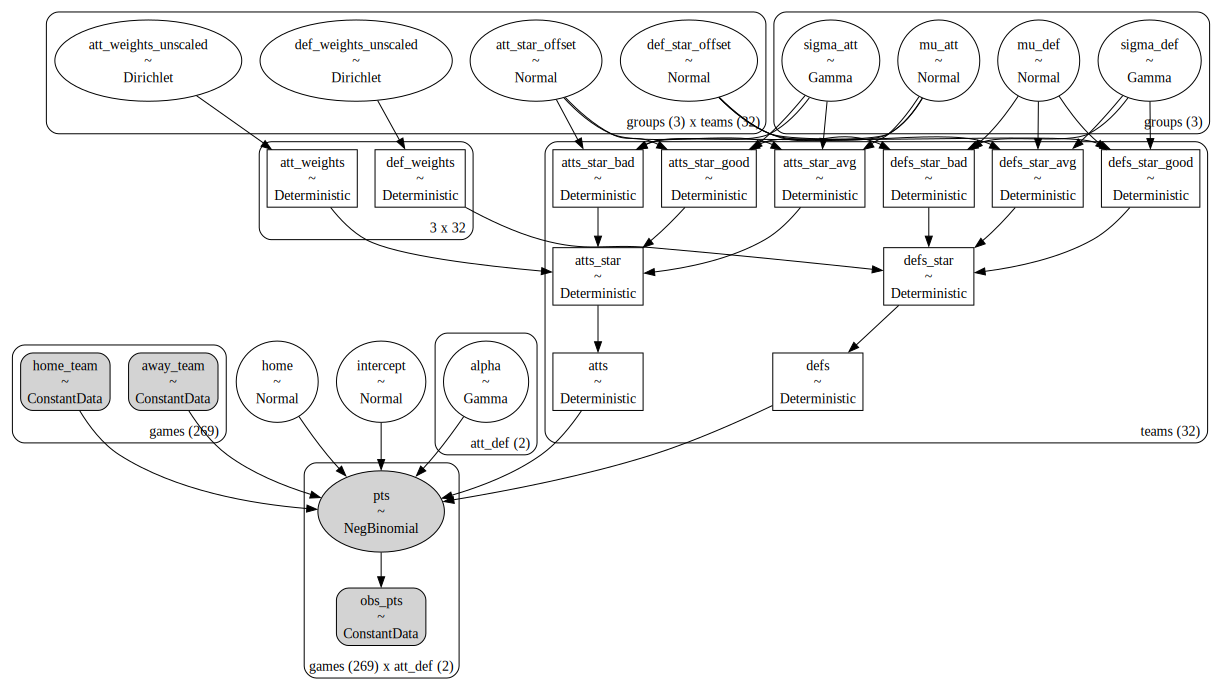

In [4]:
# Visualize model
pm.model_graph.model_to_graphviz(model.model)

In [ ]:
# Run inference on 4 cores (1 chain per core)
model.run_inference(tune=250, draws=250, target_accept=0.95, chains=4)

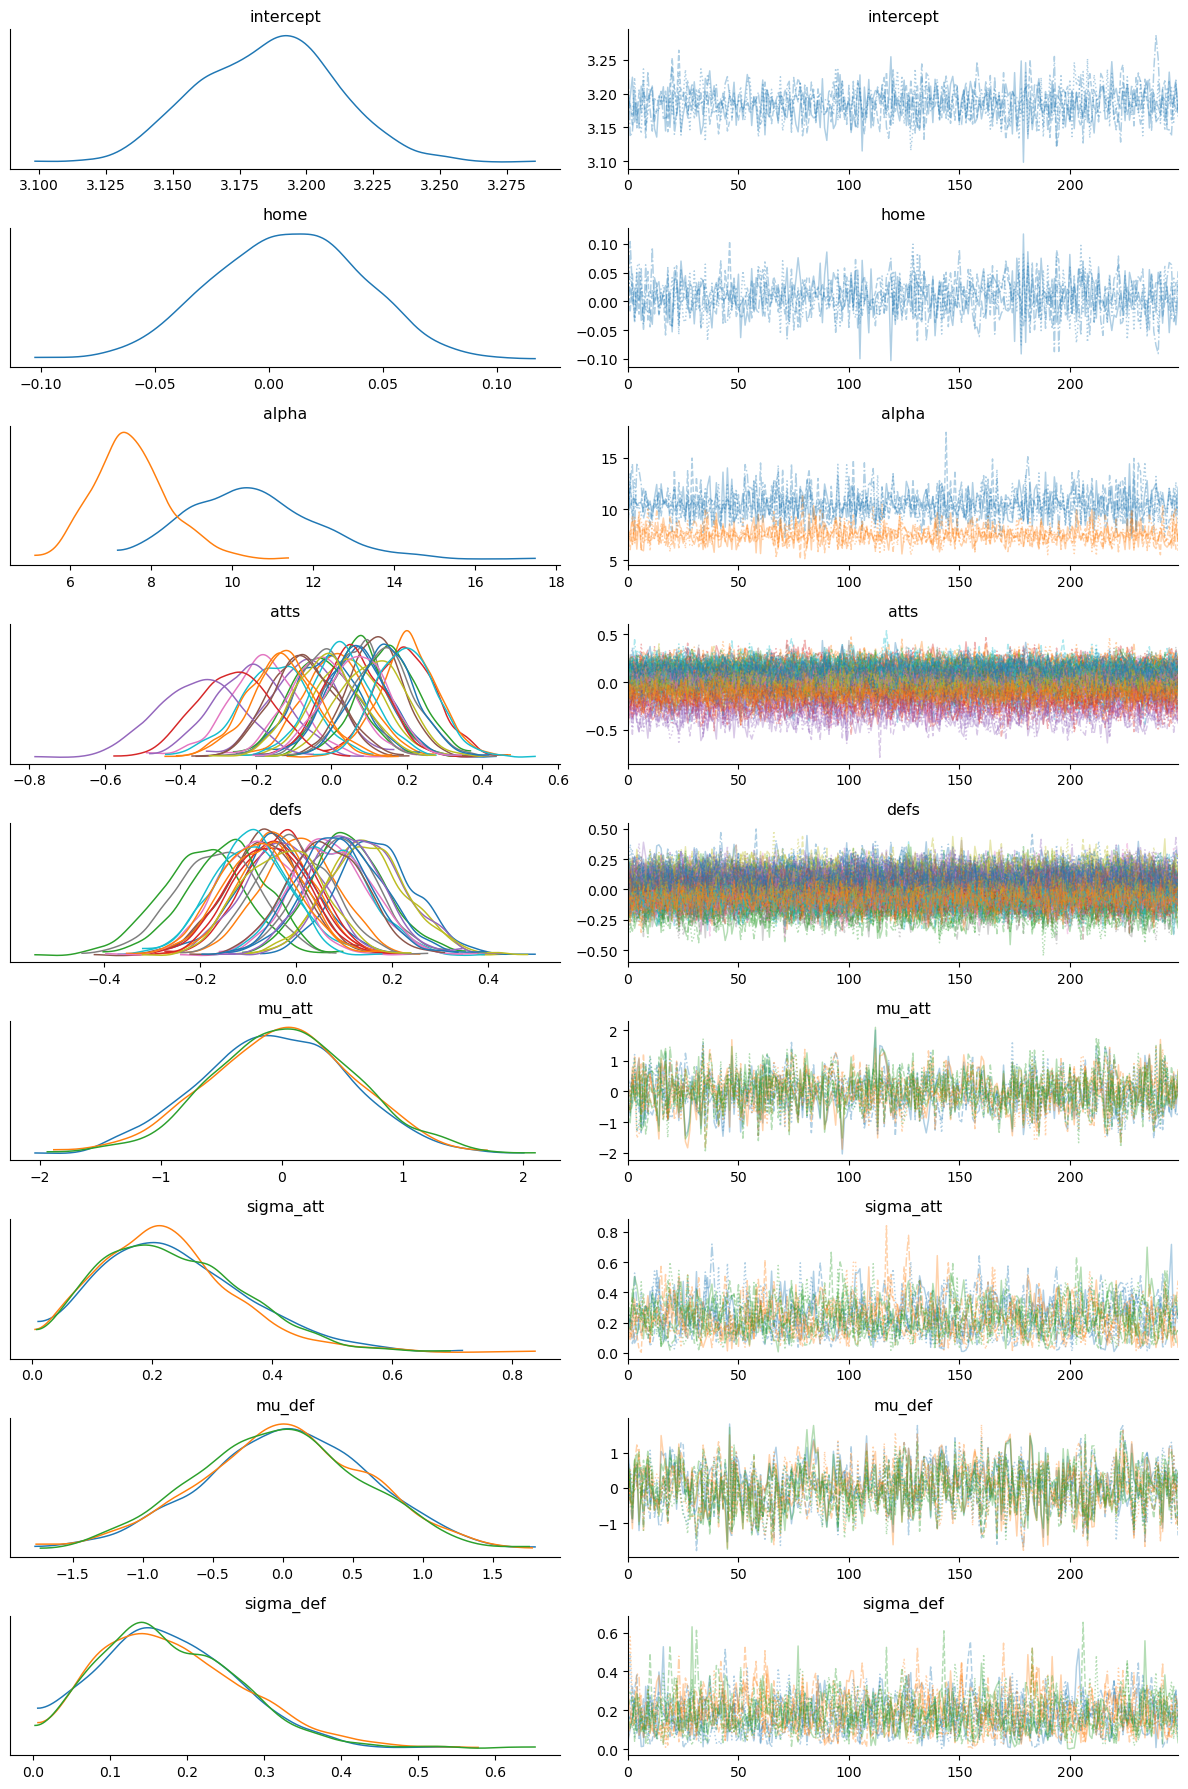

In [5]:
# Examine full posterior distributions and trace for select parameters
axes = az.plot_trace(model.trace_, compact=True, var_names=["intercept", "home", "alpha",
                                                            "atts", "defs", "mu_att", "sigma_att",
                                                            "mu_def", "sigma_def"],
                     combined=True)

for ii in range(axes.shape[0]):
    for jj in range(axes.shape[1]):
        ax = axes[ii,jj]
        sns.despine(ax=ax)
ax.get_figure().tight_layout()

In [6]:
# Examine MCMC statistics to check convergence
az.summary(model.trace_, group='posterior', var_names=['mu'], filter_vars='like')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_att[bad],-0.055,0.609,-1.256,1.037,0.021,0.018,825.0,731.0,1.01
mu_att[average],-0.012,0.607,-1.125,1.114,0.023,0.018,706.0,788.0,1.00
mu_att[good],0.029,0.602,-0.988,1.293,0.018,0.017,1105.0,737.0,1.00
mu_def[bad],0.031,0.604,-1.083,1.150,0.023,0.016,707.0,792.0,1.00
mu_def[average],0.006,0.611,-1.189,1.145,0.024,0.017,641.0,776.0,1.00
mu_def[good],-0.038,0.596,-1.148,1.060,0.023,0.017,676.0,669.0,1.00


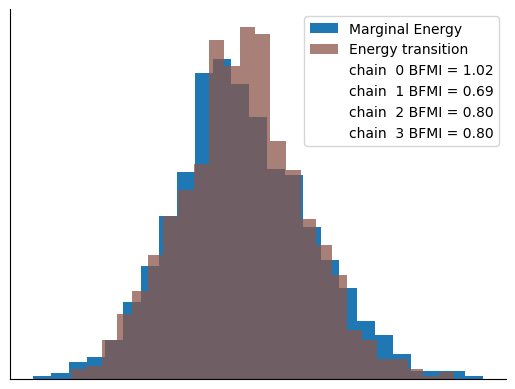

In [7]:
# Same as above, but visualizing energy of chain transition
# Should be ~1 for good convergence
ax = az.plot_energy(model.trace_, kind='hist')
sns.despine(ax=ax)

In [8]:
# Team names, medians, CIs, and colors
team_names = model.trace_.posterior.coords['teams'].values

# Calculate median, 68% CI for atts, defs for each team
med_atts = model.trace_.posterior["atts"].median(axis=1).median(axis=0).values
med_defs = model.trace_.posterior["defs"].median(axis=1).median(axis=0).values

# Calculate median, 68% CI for atts, defs for each team, convert to numpy arrays
defs_CI = az.hdi(model.trace_, var_names=["defs"], hdi_prob=0.68)
defs_CI = defs_CI.to_array().values[0]

atts_CI = az.hdi(model.trace_, var_names=["atts"], hdi_prob=0.68)
atts_CI = atts_CI.to_array().values[0]

# Get primary and secondary colors for pretty plots
pri_colors = list(map(lambda x : utils._hex_color_nfl[f"{x}_0"], team_names))
sec_colors = list(map(lambda x : utils._hex_color_nfl[f"{x}_1"], team_names))

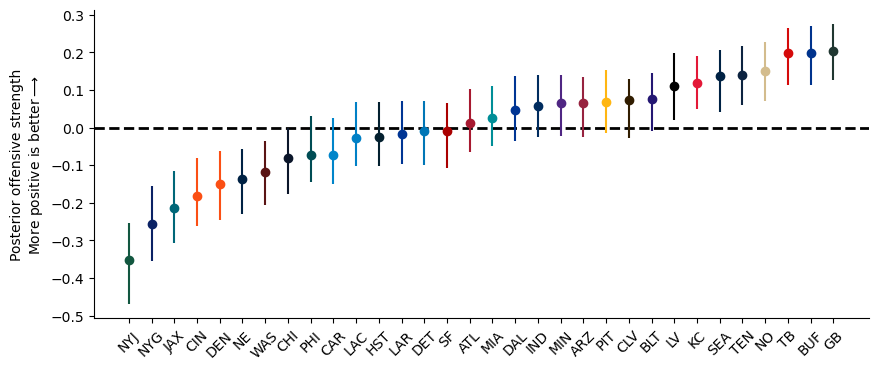

In [9]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_atts)

x = np.arange(len(med_atts))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_atts[inds[ii]], 
                yerr=np.asarray([med_atts[inds[ii]] - atts_CI[inds[ii],0], atts_CI[inds[ii],1] - med_atts[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('')
ax.set_ylabel('Posterior offensive strength\nMore positive is better$\longrightarrow$')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

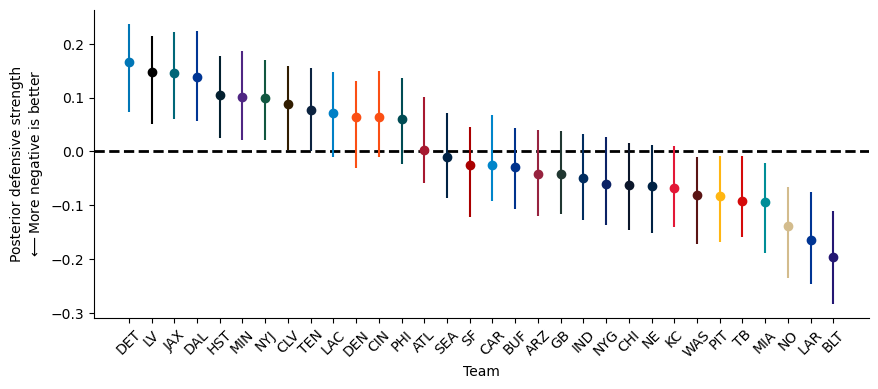

In [10]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_defs)[::-1]

x = np.arange(len(med_defs))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_defs[inds[ii]], 
                yerr=np.asarray([med_defs[inds[ii]] - defs_CI[inds[ii],0], defs_CI[inds[ii],1] - med_defs[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('Team')
ax.set_ylabel('Posterior defensive strength\n$\longleftarrow$More negative is better')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

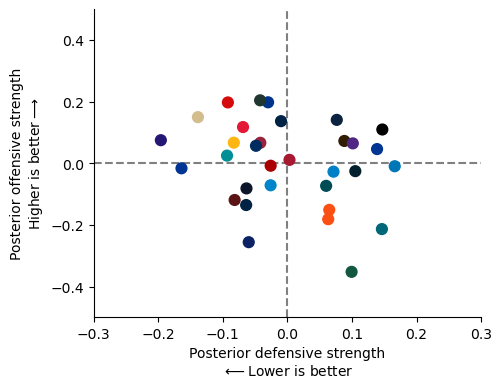

In [11]:
# Plot offensive and defensive strength together
fig, ax = plt.subplots(figsize=(5,4))

im = ax.scatter(med_defs, med_atts, s=60, zorder=1, c=pri_colors)
ax.axhline(0, lw=1.5, ls="--", color="grey", zorder=0)
ax.axvline(0, lw=1.5, ls="--", color="grey", zorder=0)

ax.set_xlabel('Posterior defensive strength\n$\longleftarrow$Lower is better')
ax.set_ylabel('Posterior offensive strength\nHigher is better$\longrightarrow$')
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.5, 0.5)
sns.despine(ax=ax)

**Simulate many games**

---

Simulate NFL results to estimate who will win, with what probability, and similar inferences for over/unders, moneyline, and spreads.

In [35]:
away_teams = ["PHI"]
home_teams = ["SEA"]
ous = [45]
home_spread = [3]
n_most = 5

for home_team, away_team, ou, hs, ii, in zip(home_teams, away_teams, ous, home_spread, np.arange(len(home_teams))):

    # Simulate n game outcomes
    home_pts, away_pts, home_win, tie = model.simulate_game(home_team, away_team, n=100, seed=None)
    
    total = home_pts + away_pts
    odds = np.mean(total > ou)
    cover = np.mean(home_pts - away_pts > -hs)
    home_ml = np.mean(home_pts > away_pts)
    
    print(f"---{away_team} at {home_team}---")
    print(f"O/U: {ou} - Over odds : {np.round(100*odds, decimals=2):.2f}%")
    print(f"Spread: {home_team} {home_spread[ii]} - odds of {home_team} cover : {np.round(100*cover, decimals=2):.2f}%") 
    print(f"ML: - odds of {home_team} ML : {np.round(100*home_ml, decimals=2):.2f}%")
    print(f"Median outcome: {away_team} {np.median(away_pts):.0f} | {home_team} {np.median(home_pts):.0f}")

    # Estimate, output n_most likely game outcomes
    if n_most is not None:
        print("Most likely game outcomes:")
        results = pd.DataFrame({"home_pts" : home_pts, "away_pts" : away_pts})
        results["pair"] = results.apply(lambda x : f"({x['home_pts']},{x['away_pts']})", axis=1)
        results = results.groupby('pair').count().reset_index().rename(columns={'home_pts' : 'counts'})[['pair', 'counts']].copy()
        results['counts'] = (100 * results['counts']) / (results['counts'].sum())
        res = results.sort_values(by='counts', ascending=False).head(n_most).values
        for ii in range(len(res)):
            t, prob = res[ii]
            home_score = int(t.split(',')[0].replace('(', ''))
            away_score = int(t.split(',')[-1].replace(')', ''))
            print(f"\t{home_team} : {home_score}, {away_team} : {away_score} with probability {prob:.2f}%")

    print("")

---PHI at SEA---
O/U: 45 - Over odds : 69.00%
Spread: SEA 3 - odds of SEA cover : 76.00%
ML: - odds of SEA ML : 69.00%
Median outcome: PHI 22 | SEA 28
Most likely game outcomes:
	SEA : 26, PHI : 20 with probability 2.00%
	SEA : 36, PHI : 28 with probability 2.00%
	SEA : 36, PHI : 21 with probability 2.00%
	SEA : 27, PHI : 23 with probability 2.00%
	SEA : 10, PHI : 15 with probability 1.00%



**Examine posterior predictive distribution**

---

Simple model evaluation method to see if model can reproduce season total points distribution.

In [ ]:
# Sample from posterior predictive distribution
with model.model:
    model.trace_.extend(pm.sample_posterior_predictive(model.trace_))

In [ ]:
ax = az.plot_ppc(model.trace_, kind='kde', num_pp_samples=100, group='posterior')
sns.despine(ax=ax)
ax.set_xlim(0, 60)
ax.set_xlabel("Total points")
ax.set_ylabel("Probability density");

In [ ]:
ax = az.plot_ppc(model.trace_, kind='cumulative', num_pp_samples=100, group='posterior')
sns.despine(ax=ax)
ax.set_xlim(0, 60)
ax.set_xlabel("Total points")
ax.set_ylabel("Cumulative probability");